In [1]:
using Distributions
using LinearAlgebra
using Plots
using DataFrames
using CSV
include("../experiments/cartpole-reach.jl")
;

load done: 15.826


In [2]:
DUMP_DIR = joinpath(@__DIR__, "..", "dump", "cartpole-reach")
# DUMP_DIR = joinpath(@__DIR__, "..", "dump", "cartpole-reach-outqc")
# DUMP_DIR = joinpath(@__DIR__, "..", "dump", "cartpole-reach-origin-bug")

colors = palette(:tab10)
used_ts = 1:8

1:8

In [3]:
# Utility functions for the cartpole plotting
function cartpole_dynamics(z::Vector, F::Real; m_cart=0.25, m_pole=0.1, l=0.4, g=9.81)
  @assert length(z) == 4
  x, dx, θ, dθ = z[1], z[2], z[3], z[4]
  M = m_pole + m_cart
  ddθ_top = g*sin(θ) + cos(θ) * ((-F - m_pole * l * dθ^2 * sin(θ)) / M)
  ddθ_bot = l * ((4/3) - (m_pole * cos(θ)^2 / M))
  ddθ = ddθ_top / ddθ_bot
  ddx_top = F + m_pole * l * (dθ^2 * sin(θ) - ddθ*cos(θ))
  ddx = ddx_top / M
  dz = [dx; ddx; dθ; ddθ]
  return dz
end

function cartpoleTraj(z1::Vector, T; dt = 0.05)
  zs = [z1]
  zt = z1
  for t in 2:T
    dzt = cartpole_dynamics(zt, 0.0)
    zt = zt + dt*zt
    push!(zs, zt)
  end
  return zs
end

function randx1(xmin, xmax)
  x1 = rand(Uniform(xmin[1], xmax[1]))
  x2 = rand(Uniform(xmin[2], xmax[2]))
  x3 = rand(Uniform(xmin[3], xmax[3]))
  x4 = rand(Uniform(xmin[4], xmax[4]))
  return Vector{Float64}([x1; x2; x3; x4])
end

function randomCartpoleTrajs(xmin, xmax, T; N = 1000)
  trajs = Vector{Any}()
  for n in 1:N
    z1 = randx1(xmin, xmax)
    traj = cartpoleTraj(z1, T)
    push!(trajs, traj)
  end
  return trajs
end

function runFeedFwdNetTraj(ffnet, x1, T)
  xs, xt = [x1], x1
  for t in 2:T
    xt = evalNet(ffnet, xt)
    push!(xs, xt)
  end
  return xs
end

function randomNeuralCartpoleTrajs(xmin, xmax, T; N = 1000)
  trajs = Vector{Any}()
  for n in 1:N
    z1 = randx1(xmin, xmax)
    traj = runFeedFwdNetTraj(ffnet_cartpole, z1, T)
    push!(trajs, traj)
  end
  return trajs
end

randomNeuralCartpoleTrajs (generic function with 1 method)

In [4]:
function loadDataFrame(β, dim)
    suffix = if (β == 0); "deepsdp__dual.csv" else "chordal__double_decomp.csv" end
    # suffix = "chordal__double_decomp.csv"
    filepath = joinpath(DUMP_DIR, "cartpole_beta$(β)_dim$(dim)_" * suffix)
    return CSV.File(filepath)
end

function loadBounds(β)
    csv1 = loadDataFrame(β, 1)
    csv2 = loadDataFrame(β, 2)
    csv3 = loadDataFrame(β, 3)
    csv4 = loadDataFrame(β, 4)
    
    x1mins, x1maxs = -1*csv1.neg_val, csv1.pos_val
    x2mins, x2maxs = -1*csv2.neg_val, csv2.pos_val
    x3mins, x3maxs = -1*csv3.neg_val, csv3.pos_val
    x4mins, x4maxs = -1*csv4.neg_val, csv4.pos_val
#     @assert length(x1mins) == length(x1maxs) == length(x2mins) == length(x2maxs)
#     @assert length(x3maxs) == length(x3maxs) == length(x4mins) == length(x4maxs)
#     @assert length(x2mins) == length(x3maxs)
    
    xmins = [[x1mins[t]; x2mins[t]; x3mins[t]; x4mins[t]] for t in 1:length(used_ts)]
    xmaxs = [[x1maxs[t]; x2maxs[t]; x3maxs[t]; x4maxs[t]] for t in 1:length(used_ts)]
    return xmins, xmaxs
end

β0mins, β0maxs = loadBounds(0)
# β1mins, β1maxs = loadBounds(1)
# β2mins, β2maxs = loadBounds(2)
# β3mins, β3maxs = loadBounds(3)
# β4mins, β4maxs = loadBounds(4)

β0_a_minmaxs = [(β0mins[t][1:2], β0maxs[t][1:2]) for t in used_ts]
β0_b_minmaxs = [(β0mins[t][3:4], β0maxs[t][3:4]) for t in used_ts]

# β1_a_minmaxs = [(β1mins[t][1:2], β1maxs[t][1:2]) for t in used_ts]
# β1_b_minmaxs = [(β1mins[t][3:4], β1maxs[t][3:4]) for t in used_ts]

# β2_a_minmaxs = [(β2mins[t][1:2], β2maxs[t][1:2]) for t in used_ts]
# β2_b_minmaxs = [(β2mins[t][3:4], β2maxs[t][3:4]) for t in used_ts]

# β3_a_minmaxs = [(β3mins[t][1:2], β3maxs[t][1:2]) for t in used_ts]
# β3_b_minmaxs = [(β3mins[t][3:4], β3maxs[t][3:4]) for t in used_ts]

# β4_a_minmaxs = [(β4mins[t][1:2], β4maxs[t][1:2]) for t in used_ts]
# β4_b_minmaxs = [(β4mins[t][3:4], β4maxs[t][3:4]) for t in used_ts]
;

In [5]:
function plotBox2D!(plt, xmin, xmax; kwargs...)
    @assert length(xmin) == length(xmax) == 2
    x1min, x1max = xmin[1], xmax[1]
    x2min, x2max = xmin[2], xmax[2]
    verts = Vector{VecReal}()
    
    push!(verts, [x1min; x2min])
    push!(verts, [x1min; x2max])
    push!(verts, [x1max; x2max])
    push!(verts, [x1max; x2min])
    push!(verts, verts[1])
    
    plt = Utils.plotSeqPoints!(plt, verts; kwargs...)
    return plt
end

function OldplotTrajBoxes!(plt, β, mode=:x1x2; kwargs...)
    if β == 0; lbs, ubs = β0mins, β0maxs
    elseif β == 1; lbs, ubs = β1mins, β1maxs
    elseif β == 2; lbs, ubs = β2mins, β2maxs
    elseif β == 3; lbs, ubs = β3mins, β3maxs
    elseif β == 4; lbs, ubs = β4mins, β4maxs
    else error("unsupported β: $(β)")
    end
    
    @assert length(lbs) == length(ubs)
    
    if mode == :x1x2; min_maxes = [(lbs[t][1:2], ubs[t][1:2]) for t in used_ts]
    elseif mode == :x3x4; min_maxes = [(lbs[t][3:4], ubs[t][3:4]) for t in used_ts]
    else error("unsupported mode: $(mode)")
    end
    
    my_plt = plt
    # The initial conditions
    if mode == :x1x2; plotBox2D!(my_plt, x1min[1:2], x1max[1:2]; kwargs...)
    else; plotBox2D!(my_plt, x1min[3:4], x1max[3:4]; kwargs...)
    end
    
    for (xmin, xmax) in min_maxes
        my_plt = plotBox2D!(my_plt, xmin, xmax; kwargs...)
    end
    return my_plt
end


function plotTrajBoxes!(plt, β, dx, dy; kwargs...)
    if β == 0; lbs, ubs = β0mins, β0maxs
    elseif β == 1; lbs, ubs = β1mins, β1maxs
    elseif β == 2; lbs, ubs = β2mins, β2maxs
    elseif β == 3; lbs, ubs = β3mins, β3maxs
    elseif β == 4; lbs, ubs = β4mins, β4maxs
    else error("unsupported β: $(β)")
    end
    
    @assert length(lbs) == length(ubs)
    
    min_maxs = [(lbs[t][[dx; dy]], ubs[t][[dx;dy]]) for t in used_ts]
    
    # Initial conditions
    plotBox2D!(plt, x1min[[dx;dy]], x1max[[dx;dy]]; color=colors[1], linestyle=:solid, linewidth=2, kwargs...)
    for (xmin, xmax) in min_maxs; plt = plotBox2D!(plt, xmin, xmax; color=colors[2], linestyle=:dash, kwargs...) end    
    return plt
end

plotTrajBoxes! (generic function with 1 method)

In [6]:
# trajs = randomCartpoleTrajs(x1min, x1max, 8)
trajs = randomNeuralCartpoleTrajs(x1min, x1max, 8)
;

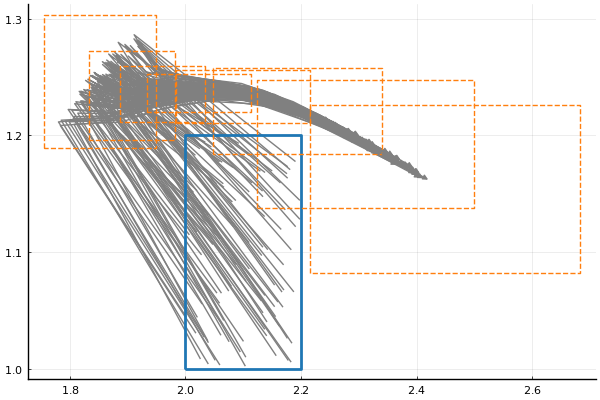

In [7]:
dx, dy = 1, 2
plt = plot()
for n in 1:100
   Utils.plotSeqPoints!(plt, [t[[dx;dy]] for t in trajs[n]], color=:gray, arrow=true)
end
plt = plot!(plt, legend=false)
plotTrajBoxes!(plt, 0, dx, dy,
#     color=:red,
#     linestyle=:dot,
#     xlim=(1.5,3.0),
#     ylim=(-1.5,0.4)
)

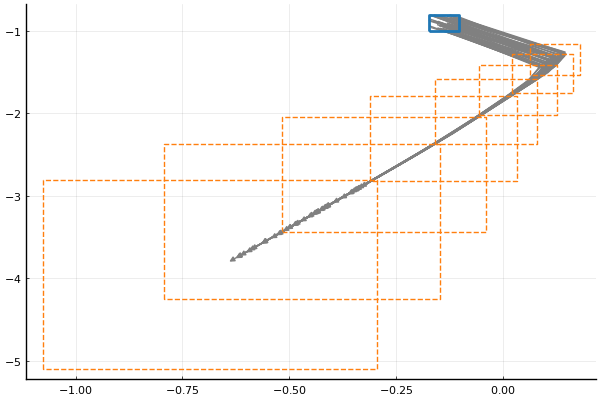

In [8]:
dx, dy = 3,4
plt = plot()
for n in 1:50
   Utils.plotSeqPoints!(plt, [t[[dx;dy]] for t in trajs[n]], color=:gray, arrow=true)
end
plt = plot!(plt, legend=false)
plotTrajBoxes!(plt, 0, dx, dy,
#     color=:red,
#     linestyle=:dot,
#     xlim=(0.92,1.38),
#     ylim=(-6,0)
)